In [1]:
import os, sys, time, math, shutil
from natsort import natsorted

import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

import glob
from tifffile import imwrite
import json 

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

import utils
from utils import average_images, flatField, getReference, displayResult, fitnessMSE, fitnessRMSE, fitnessMAE, fitnessSSIM, fitnessZNCC, getXrayImage
from utils import bbox, plot_directory, applyTransformation, inverseX, rescaleX

from utils import compareMAE, compareMSE, compareZNCC, compareSSIM, compareRMSE
from utils import fitnessHOGwithMAE, fitnessHOGwithMSE, fitnessHOGwithZNCC, fitnessHOGwithRMSE

Mon Nov 27 15:49:20 2023 (WW) Spekpy is not installed, try Xpecgen instead.
Mon Nov 27 15:49:20 2023 (WW) Xpecgen is not installed either.


spekpy is not install, you won't be able to load a beam spectrum using spekpy
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.8 (2023-11-20T14:28:40) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.8 (2023-11-20T14:28:40) [Compiler: GNU g++] on Linux


In [2]:
utils.use_padding = False
utils.pad_width = 50
angular_step_in_deg = 3.6

downsample = True

In [3]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
#data_path = "4thOCtober_image/"
#data_path = "4thCotober_imageAngle/"
data_path = "25OctoberData/"
#data_path = "15NovemberData/"
data_path = "24NovemberData/"

In [4]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

json_file = current_folder + "/simulation2.json"

/home/fpvidal/PROGRAMMING/GitHub/MyProjects


In [5]:
# dirs = [
#     current_folder + "/" + data_path + "/plot1",
#     current_folder + "/" + data_path + "/plot2"
# ]

# for directory in dirs:
#     if os.path.isdir(directory):
#         shutil.rmtree(directory)

#     if not os.path.exists(directory):
#         os.mkdir(directory)

In [6]:
#path for my recently acquired images stored in PhD file



dark_field_paths = glob.glob(data_path + '/darkfd/darkfd_*.tiff')
dark_field_paths = natsorted(dark_field_paths, key=lambda y: y.lower())

white_field_paths = glob.glob(data_path + '/whitefd/whitefd_*.tiff')
white_field_paths = natsorted(white_field_paths, key=lambda y: y.lower())

raw_image_paths = glob.glob(data_path + '/raw_images/raw_image_*.tiff')
raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

if len(raw_image_paths) == 0:
    raw_image_paths = glob.glob(data_path + '/rawimages/raw_images_*.jpg')
    raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

In [7]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths, downsample)
I_white = average_images(white_field_paths, downsample)

In [8]:
I_raw = []
angles_in_deg = []
for i, fname in enumerate(raw_image_paths):

    angle = angular_step_in_deg * i

    if angle < 360.000001:
        angles_in_deg.append(angular_step_in_deg * i)
        I_raw.append(cv2.imread(fname, 
                               cv2.IMREAD_GRAYSCALE))
    
        if downsample:
            I_raw[-1] = cv2.pyrDown(I_raw[-1])

        if utils.use_padding:
            median_value = np.median(I_raw[-1])
            I_raw[-1] = np.pad(I_raw[-1], (pad_width, pad_width), 'constant', constant_values=(median_value, median_value))

I_raw = np.array(I_raw, dtype=np.single)
# I_raw = average_images(raw_image_paths)

# for image in I_raw:
#     image /= np.mean(image[:,0:200])

# I_white /= np.mean(I_white[:,0:200])
# I_dark /= np.mean(I_dark[:,0:200])

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# Clamp pixel values
I_flat1[I_flat1<0] = 0
I_flat2[I_flat2<0] = 0

I_flat1[I_flat1>1] = 1
I_flat2[I_flat2>1] = 1

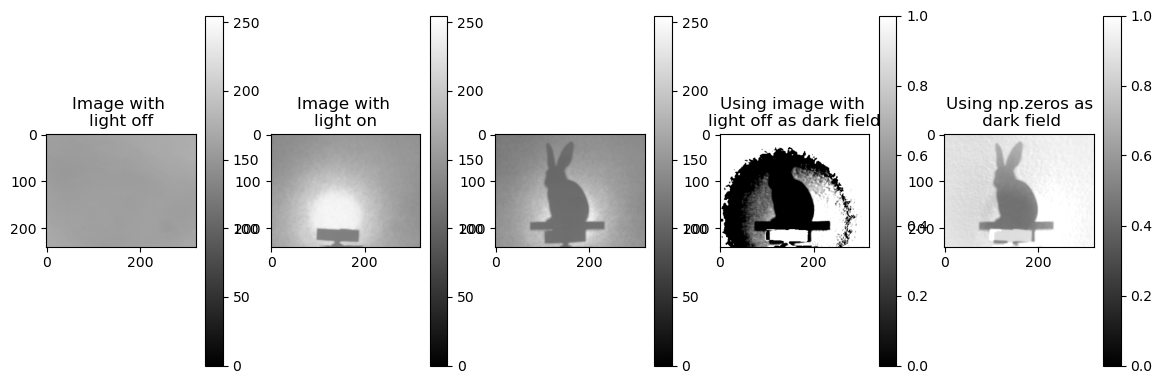

In [9]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

In [10]:
I_flat = I_flat2


I_flat = []
for img in I_flat2:
    ret, binary_image = cv2.threshold((255 * img).astype(np.uint8), 127, 255, cv2.THRESH_OTSU)
    I_flat.append(binary_image)
    
I_flat = np.array(I_flat, dtype=np.uint8)

In [11]:
if not os.path.exists(data_path + "/flat_images"):
    os.mkdir(data_path + "/flat_images")

for i, img in enumerate(I_flat):
    imwrite(data_path + "/flat_images/projection_" + str(i).zfill(4) + ".tif", img)

In [12]:
#sod = 43
#sod =47
#sod = 48
#sdd = 61
#for rabbit
#sod=41
#sdd=51
sod=104
sdd=130
#sod = 25
#sdd=61

In [13]:
utils.data_range = [[-50, -500, -50, # source position
                   -50,    0, -50,  # detector position
                   -50, -50,  # object position on turntable
                   -180, -180], # object orientation
                  
                  [ 50,    0, 50,   # source position
                    50, 500, 50,   # detector position
                    50,  50,   # object position on turntable
                    180,  180]]; # object orientation

In [14]:
Ti90Al10 = 5.68
x_src = 0
y_src = -sod
z_src = 0

x_det = 0
y_det = (sdd - sod)
z_det = 0

x_rot = 0
y_rot = 0
z_rot = 0

x_obj = 0
y_obj = 0
z_obj = 0

#for "25OctoberData/"
alpha_x =  90 
alpha_y = -90
alpha_z =   0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_obj,
    y_obj,
    
    alpha_x,
    alpha_y,
]

x_default = inverseX(x_default)

In [15]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR(json_file, "OPENGL", 3, 2)

Create an OpenGL context: 800x600


Mon Nov 27 15:36:58 2023 ---- Create window (ID: -1)
Mon Nov 27 15:36:58 2023 ---- Initialise GLFW
Mon Nov 27 15:36:58 2023 ---- Create an OpenGL window with a 3.2 context.
Mon Nov 27 15:36:58 2023 ---- Make the window's context current
Mon Nov 27 15:36:58 2023 ---- Initialise GLEW
Mon Nov 27 15:36:58 2023 ---- OpenGL vendor: NVIDIA Corporation
Mon Nov 27 15:36:58 2023 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Mon Nov 27 15:36:58 2023 ---- OpenGL version: 3.2.0 NVIDIA 535.104.05
Mon Nov 27 15:36:58 2023 ---- Use OpenGL 4.5.
Mon Nov 27 15:36:58 2023 ---- Initialise the X-ray renderer if needed and if possible


In [16]:
# Load our source properties
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [17]:
# Load our detector
json2gvxr.initDetector()
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

if downsample:
    detector_size = np.array(gvxr.getDetectorSize("mm"));

    old_number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels());
    gvxr.setDetectorNumberOfPixels(old_number_of_pixels[0] // 2, old_number_of_pixels[1] // 2);    
    new_number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels());

    spacing = detector_size / new_number_of_pixels
    

    gvxr.setDetectorPixelSize(spacing[0], spacing[1], "mm");
    
    print("\tDetector number of pixels:", new_number_of_pixels)
    print("\tPixel spacing:", spacing, "mm")

if utils.use_padding:
    number_of_pixels = gvxr.getDetectorNumberOfPixels();
    gvxr.setDetectorNumberOfPixels(number_of_pixels[0] + 2 * pad_width, number_of_pixels[1] + 2 * pad_width);

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']
	Detector number of pixels: [320 240]
	Pixel spacing: [0.45999999 0.46000001] mm


Mon Nov 27 15:36:58 2023 ---- Initialise the renderer
Mon Nov 27 15:36:58 2023 ---- Initialise the renderer


In [18]:
# Load our samples
json2gvxr.initSamples(json_file, verbose=0)

gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

Mon Nov 27 15:36:58 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/MyProjects/Rabbit.stl	nb_faces:	75710	nb_vertices:	227130	bounding_box (in cm):	(-1.14473, -1.27, -1.20062)	(1.14473, 1.27, 1.20062)
Mon Nov 27 15:36:58 2023 (WW) PolygonMesh cuboid not found in g_p_polygon_mesh_set.


In [19]:
utils.default_up_vector    = gvxr.getDetectorUpVector();
utils.default_right_vector = gvxr.getDetectorRightVector();

In [20]:
gvxr.computeXRayImage();
gvxr.displayScene()
gvxr.setZoom(400)
gvxr.setSceneRotationMatrix([0.6925417184829712, 0.010556249879300594, -0.7213009595870972, 0.0, -0.7204560041427612, 0.060654886066913605, -0.6908417344093323, 0.0, 0.036457497626543045, 0.998101532459259, 0.04961010813713074, 0.0, 0.0, 0.0, 0.0, 1.0])

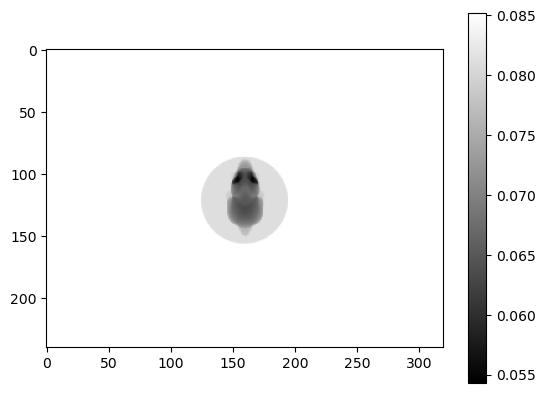

In [21]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [22]:
utils.figsize = (15, 12)
utils.ref_image, utils.selected_angles, utils.indices = getReference(I_flat, angles_in_deg, 4)

In [23]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-4);
opts['tolx'] = 1e-4;
opts['bounds'] = [10*[-1], 10*[1]];

x_fname       = current_folder + "/" + data_path + "/x_best1.dat"
fitness_fname = current_folder + "/" + data_path + "/fitness_set1.npz"
utils.plot_directory = current_folder + "/" + data_path + "/plot1"

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    

    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.25, opts);
    es.optimize(fitnessZNCC);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best1 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]
    
x_current = rescaleX(x_best1)

Text(0, 0.5, 'Fitness value (ZNCC in %)')

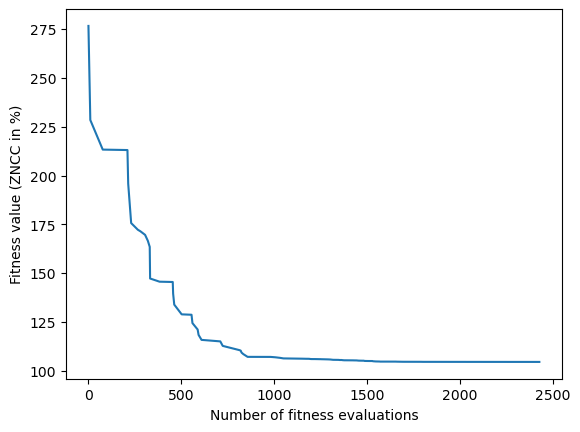

In [24]:
plt.plot(utils.fitness_set[:,0], 100 * 1.0 / utils.fitness_set[:,1])
plt.xlabel("Number of fitness evaluations")
plt.ylabel("Fitness value (ZNCC in %)")

In [25]:
print(rescaleX(x_best1))

[-21.164269651322353, -125.29045279961326, -8.564602774998548, 39.75268184343004, 259.6754551209053, 15.481295359864262, 0.5014640353086435, 1.3977601282420622, 89.42092205241437, -161.97412277901208]


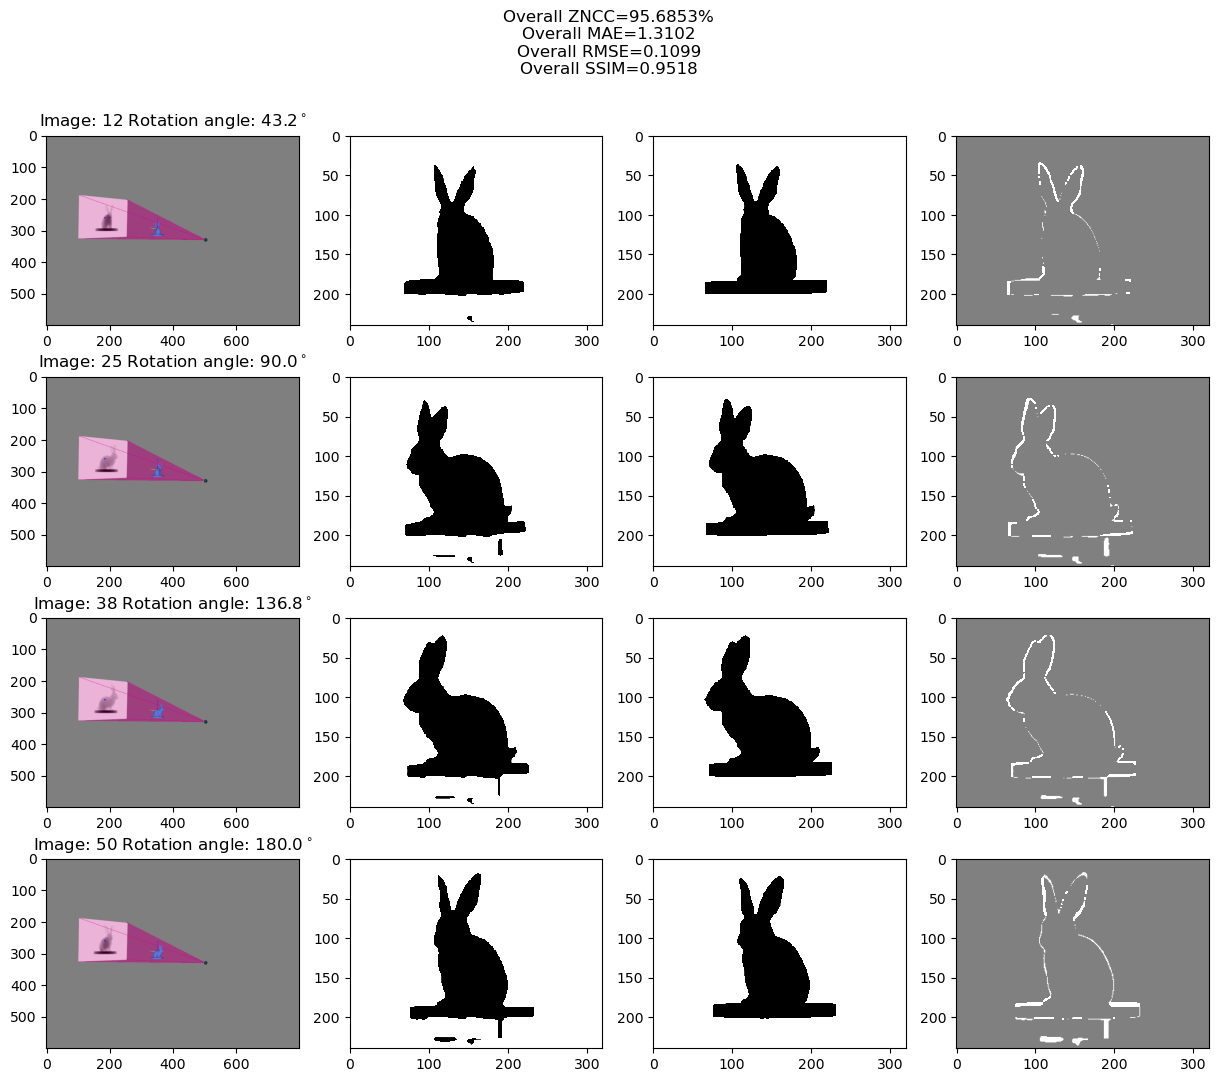

In [26]:
displayResult(x_best1, figsize=(15, 12))

In [27]:
opts.set('tolfun', 1e-4);
opts['tolx'] = 1e-4;
opts['bounds'] = [12*[-1], 12*[1]];

x_fname       = current_folder + "/" + data_path + "/x_best2.dat"
fitness_fname = current_folder + "/" + data_path + "/fitness_set2.npz"
utils.plot_directory = current_folder + "/" + data_path + "/plot2"

utils.data_range = [[x_current[ 0] - 50, x_current[ 1] - 50, x_current[ 2] - 50,  # source position
                   x_current[ 3] - 50, x_current[ 4] - 50, x_current[ 5] - 50,  # detector position
                   x_current[ 6] - 50, x_current[7] - 50,   # object position on turntable
                   x_current[8] - 50, x_current[9] - 50,                      # object orientation
                   -10, -10],                                                   # detector orientation
                  
                  [x_current[ 0] + 50, x_current[ 1] + 50, x_current[ 2] + 50,  # source position
                   x_current[ 3] + 50, x_current[ 4] + 50, x_current[ 5] + 50,  # detector position
                   x_current[ 6] + 50, x_current[7] + 50,   # object position on turntable
                   x_current[8] + 50, x_current[9] + 50,                      # object orientation
                   10, 10]]                                                     # detector orientation                  

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    
    
    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1
        
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(12*[0.0], 0.1, opts);
    es.optimize(fitnessRMSE);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)
    
else:
    x_best2 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]
    
x_current = rescaleX(x_best2)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=168370, Mon Nov 27 15:37:01 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 3.842691249849078e-01 1.0e+00 1.40e-01  1e-01  1e-01 0:01.8
    2     22 3.807630086418585e-01 1.2e+00 1.29e-01  1e-01  1e-01 0:03.5
    3     33 3.135451273341686e-01 1.2e+00 1.20e-01  1e-01  1e-01 0:05.2
   10    110 3.159136468905177e-01 1.7e+00 1.10e-01  9e-02  1e-01 0:08.4
   14    154 3.527237764880616e-01 1.9e+00 9.96e-02  8e-02  1e-01 0:12.4
   25    275 2.740395158549219e-01 2.7e+00 7.38e-02  5e-02  9e-02 0:17.5
   39    429 2.281107301472978e-01 3.8e+00 5.63e-02  3e-02  7e-02 0:24.8
   45    495 2.070297759381486e-01 4.2e+00 3.85e-02  2e-02  5e-02 0:32.2
   50    550 1.737960820185541e-01 5.3e+00 4.09e-02  2e-02  6e-02 0:40.8
   72    792 1.559267489613846e-01 8.2e+00 2.28e-02  8e-03  3e-02 0:50.9
   84    924 1.339746944389126e-01 1.1e+01 2.11e-02  6e-03  3e-02 1:02.5
   93   1023 1.256234452640111e-0

Text(0, 0.5, 'Fitness value (RMSE)')

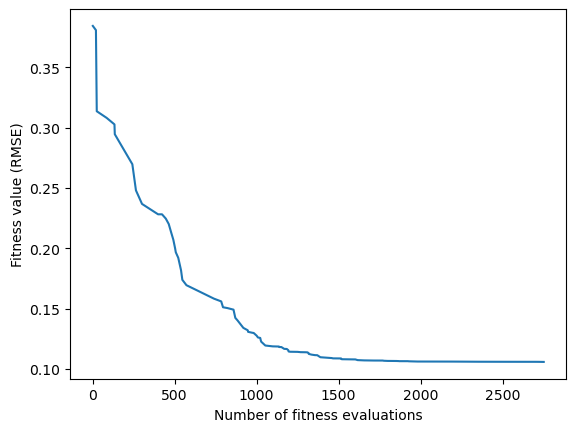

In [28]:
plt.plot(utils.fitness_set[:,0], utils.fitness_set[:,1])
plt.xlabel("Number of fitness evaluations")
plt.ylabel("Fitness value (RMSE)")

In [29]:
print(x_current)

[-22.289201459203767, -119.31715685455029, -6.806212253133552, 42.65503673588627, 250.89659826346258, 12.359905092189827, 0.5421815780070105, 1.4034032964337797, 86.57035317417679, -163.06418726825393, 5.722173965785091, 2.379054780759944]


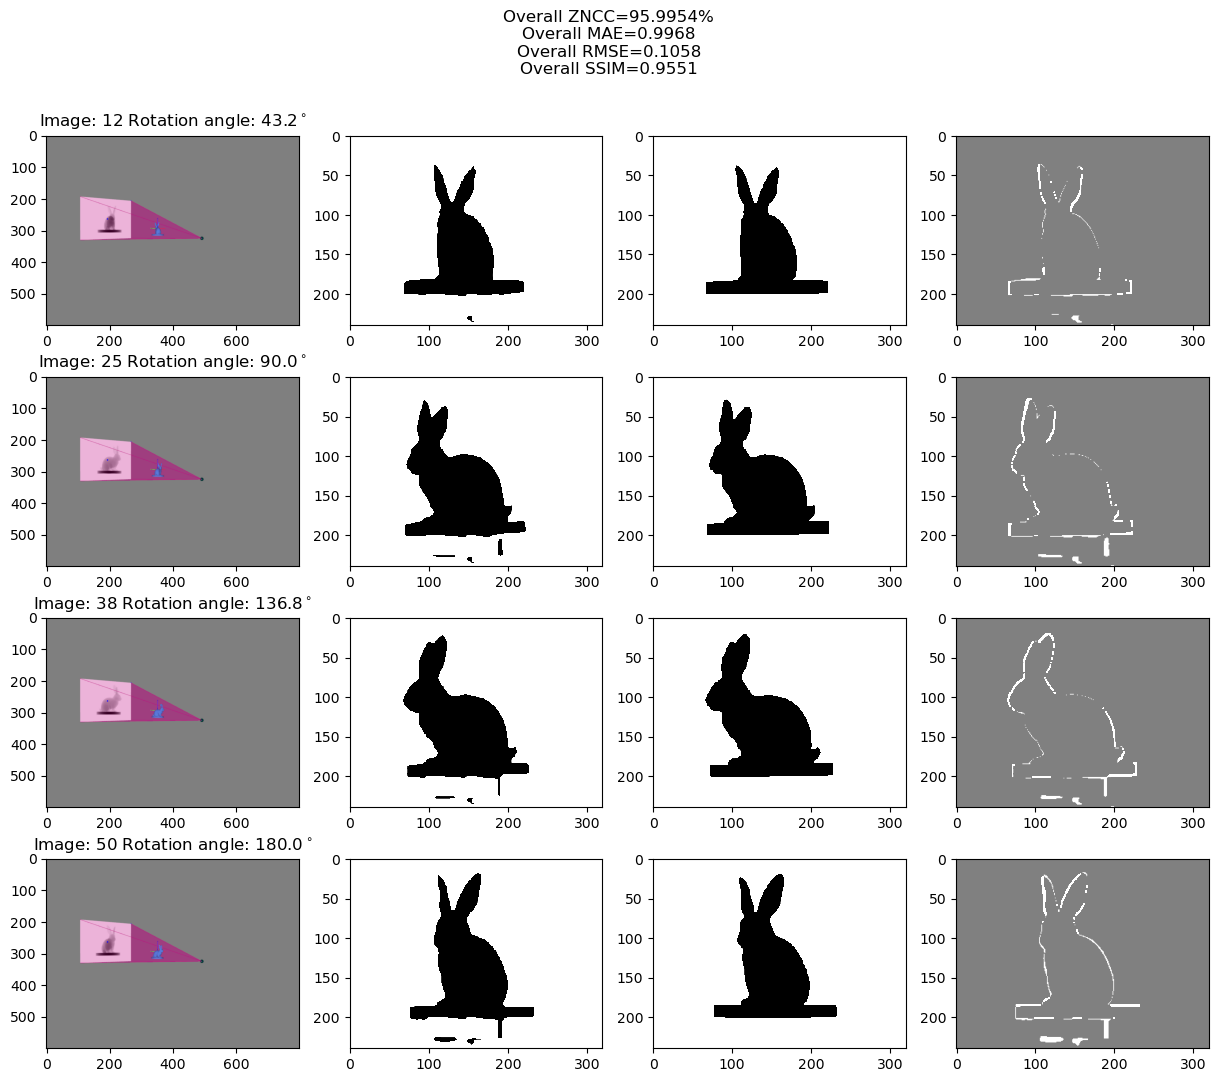

In [30]:
displayResult(x_best2, figsize=(15, 12))

In [31]:
def getCentreOfRotationPosition(x):
   
    x_rot_axis_pos = 0
    y_rot_axis_pos = 0
    z_rot_axis_pos = 0

    return np.array([x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos])

    # Global coordinates
    return np.array([(utils.bbox[0] + utils.bbox[3]) / 2,
                    (utils.bbox[1] + utils.bbox[4]) / 2,
                    (utils.bbox[2] + utils.bbox[5]) / 2])

def getSourcePosition(x):
    return np.array([x[0], x[1], x[2]])
    
def getDetectorPosition(x):
    return np.array([x[3], x[4], x[5]])
    
def getRotationAxisPosition(x):
    x_rot_axis_pos = x[6]
    y_rot_axis_pos = x[7]
    z_rot_axis_pos = x[8]

def printX(x):



    x_obj = x[6]
    y_obj = x[7]
    z_obj = 0
    
    alpha_x = x[8]
    alpha_y = x[9]
    # alpha_z = x[14]

    print("Source position:", getSourcePosition(x), "mm")
    print("Detector position:", getDetectorPosition(x), "mm")
    print("Source-Detector Distance (SDD):", math.sqrt(math.pow(x_src - x_det, 2) + math.pow(y_src - y_det, 2) + math.pow(z_src - z_det, 2)), "mm")
    print("Object position:", x_obj, y_obj, z_obj, "mm")
    print("Centre of rotation position:", getCentreOfRotationPosition(x), "mm")
    print("Tilt around", utils.default_up_vector, ":", x[10], "degrees")
    print("Tilt around", utils.default_right_vector, ":", x[11], "degrees")

printX(x_current)

Source position: [ -22.28920146 -119.31715685   -6.80621225] mm
Detector position: [ 42.65503674 250.89659826  12.35990509] mm
Source-Detector Distance (SDD): 130.0 mm
Object position: 0.5421815780070105 1.4034032964337797 0 mm
Centre of rotation position: [0 0 0] mm
Tilt around (0.0, 0.0, -1.0) : 5.722173965785091 degrees
Tilt around (-1.0, 0.0, 0.0) : 2.379054780759944 degrees


In [32]:
applyTransformation(x_best2)

(-13.906109809875488,
 -7.492693901062012,
 -12.189640045166016,
 14.990472793579102,
 10.29949951171875,
 12.189640998840332)

In [33]:
def saveJSON(x, fname, image_path):

    x_rot_axis_pos = 0
    y_rot_axis_pos = 0
    z_rot_axis_pos = 0

    x_obj = x[6]
    y_obj = x[7]
    z_obj = 0

    alpha_x = x[8]
    alpha_y = x[9]
    # alpha_z = x[14]

    dictionary = {}

    dictionary["WindowSize"] = [800, 600]
    dictionary["Detector"] = {}
    dictionary["Detector"]["Position"] = [
        getDetectorPosition(x)[0],
        getDetectorPosition(x)[1],
        getDetectorPosition(x)[2],
        "mm"]
    dictionary["Detector"]["UpVector"] = gvxr.getDetectorUpVector()
    dictionary["Detector"]["RightVector"] = gvxr.getDetectorRightVector()
    dictionary["Detector"]["NumberOfPixels"] = gvxr.getDetectorNumberOfPixels()
    dictionary["Detector"]["Size"] = [
        gvxr.getDetectorSize("mm")[0],
        gvxr.getDetectorSize("mm")[1],
        "mm"]

    dictionary["Source"] = {}
    dictionary["Source"]["Position"] = [
        getSourcePosition(x)[0],
        getSourcePosition(x)[1],
        getSourcePosition(x)[2],
        "mm"]
    dictionary["Source"]["Shape"] = "PointSource"
    dictionary["Source"]["Beam"] = []
    
    for energy, count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):
        dictionary["Source"]["Beam"].append({})
        dictionary["Source"]["Beam"][-1]["Energy"] = energy
        dictionary["Source"]["Beam"][-1]["Unit"] = "keV"
        dictionary["Source"]["Beam"][-1]["PhotonCount"] = count

    dictionary["Samples"] = []
    
    for mesh in json2gvxr.params["Samples"]:
        dictionary["Samples"].append({})
        dictionary["Samples"][-1]["Label"] = mesh["Label"]
        dictionary["Samples"][-1]["Path"] = "../" + mesh["Path"]
        dictionary["Samples"][-1]["Unit"] = mesh["Unit"]
        dictionary["Samples"][-1]["Material"] = mesh["Material"]
        dictionary["Samples"][-1]["Density"] = mesh["Density"]
    
        dictionary["Samples"][-1]["Transform"] = []
        dictionary["Samples"][-1]["Transform"].append(["Translation", x_obj, y_obj, z_obj, "mm"])
        dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_x, 1, 0, 0])
        dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_y, 0, 1, 0])
        dictionary["Samples"][-1]["Transform"].append(["Rotation", alpha_z, 0, 0, 1])
    
    dictionary["Scan"] = {}
    rot_centre = getCentreOfRotationPosition(x)
    # rot_centre = [x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos] # local
    dictionary["Scan"]["CenterOfRotation"] = [
        x_rot_axis_pos,
        y_rot_axis_pos,
        z_rot_axis_pos,
        "mm"]
    
    dictionary["Scan"]["FinalAngle"] = (I_flat.shape[0] - 1) * 3.6
    dictionary["Scan"]["IncludeFinalAngle"] = True
    dictionary["Scan"]["NumberOfProjections"] = I_flat.shape[0]
    dictionary["Scan"]["GifPath"] = "preview.gif"
    dictionary["Scan"]["OutFolder"] = image_path
    dictionary["Scan"]["Flat-Field Correction"] = True
    
    
    # Convert and write JSON object to file
    with open(fname, "w") as outfile: 
        json.dump(dictionary, outfile, indent = 4)


visible_light_CT_json_file = current_folder + "/" + data_path + "/visible_light.json"
simulated_CT_json_file = current_folder + "/" + data_path + "/simulation.json"

saveJSON(x_current, visible_light_CT_json_file, "flat_images/")
saveJSON(x_current, simulated_CT_json_file,     "simulation/")